### A simple notebook to test and evaluate the image quality from the images generated by the DCGAN 

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import glob

In [2]:
ATTACK="FGSM"
ITERATION=14
BATCH=128

In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = 1
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(64*8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*8, 100, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.main(x).view(x.size(0), -1)

## Learning Rates

In [30]:
DELTA=0.01

In [31]:
checkpoint_files = sorted(glob.glob(f'../DCGAN/{ATTACK}/Models/Delta-{DELTA:.02f}/Best-Checkpoint-{ATTACK}-Delta-{DELTA:.02f}-*.pth'))

In [32]:
epochs = []
lr_G = []
lr_D = []

for checkpoint_path in checkpoint_files:
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'), weights_only=True)
    
    epoch = checkpoint['epoch']
    lrG = checkpoint['optimizerG_state_dict']['param_groups'][0]['lr']
    lrD = checkpoint['optimizerD_state_dict']['param_groups'][0]['lr']

    epochs.append(epoch)
    lr_G.append(lrG)
    lr_D.append(lrD)

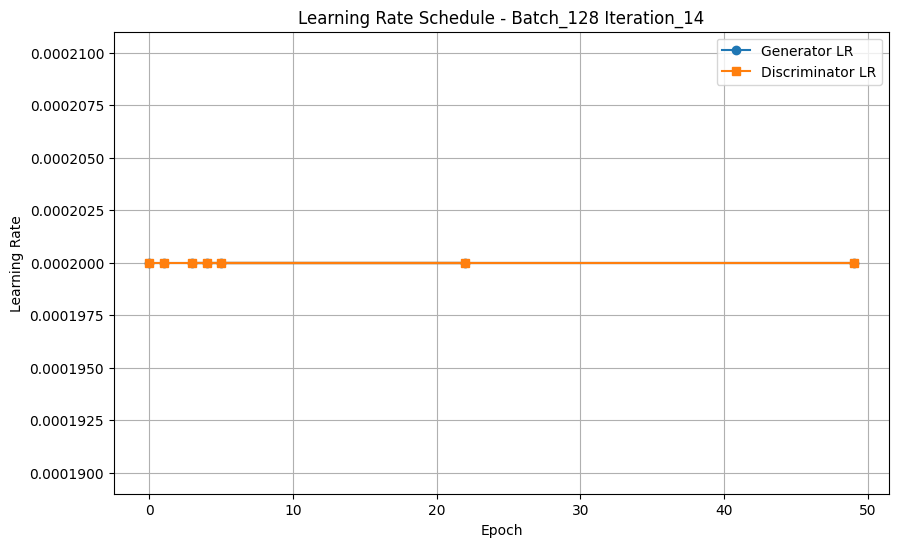

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, lr_G, label="Generator LR", marker='o')
plt.plot(epochs, lr_D, label="Discriminator LR", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title(f"Learning Rate Schedule - Batch_{BATCH} Iteration_{ITERATION}")
plt.legend()
plt.grid()
plt.show()

## Losses

In [35]:
BEST_CHECKPOINT_G=22

In [36]:
# CHECKPOINT ENCODER
checkpoint_path_encoder = f"../DCGAN/{ATTACK}/Models/Encoder-Delta-{DELTA:.02f}/Encoder.pth"
checkpoint_encoder = torch.load(checkpoint_path_encoder, map_location=device, weights_only=True)

In [37]:
# CHECKPOINT GENERATOR
checkpoint_path = f"../DCGAN/{ATTACK}/Models/Delta-{DELTA:.02f}/Best-Checkpoint-{ATTACK}-Delta-{DELTA:.02f}-Epoch-{BEST_CHECKPOINT_G}-128.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

In [38]:
d_loss = checkpoint['D_loss']
g_loss = checkpoint['G_loss']

In [39]:
step = int(len(d_loss)/BEST_CHECKPOINT_G)

In [40]:
d_loss = [float(x) for x in d_loss if isinstance(x, (int, float))]
g_loss = [float(x) for x in g_loss if isinstance(x, (int, float))]

In [41]:
aggregated_loss_d = [np.mean(d_loss[i:i+step]) for i in range(0, len(d_loss), step)]
aggregated_loss_g = [np.mean(g_loss[i:i+step]) for i in range(0, len(g_loss), step)]

In [42]:
loss_encoder = checkpoint_encoder['encoder_losses']
step_encoder = int(len(d_loss)/200)
loss_encoder = [float(x) for x in loss_encoder if isinstance(x, (int, float))]
aggregated_loss_e = [np.mean(loss_encoder[i:i+step_encoder]) for i in range(0, len(loss_encoder), step)]

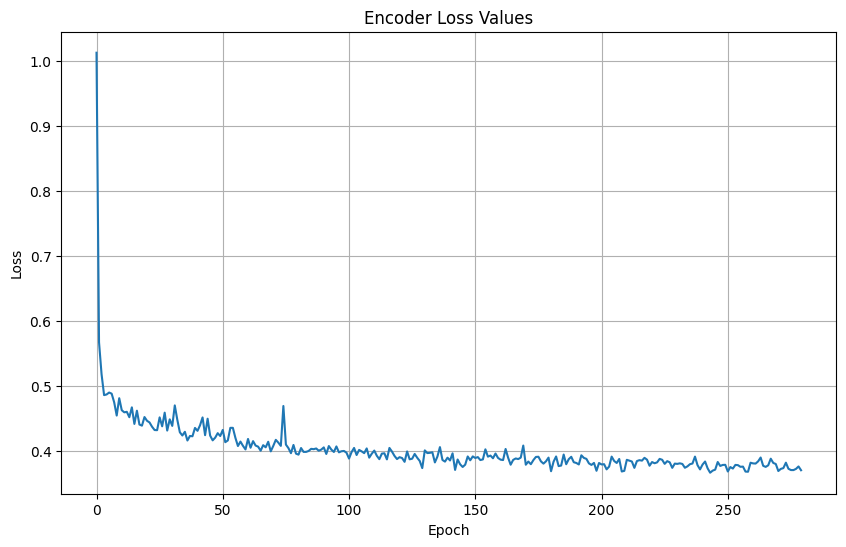

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(aggregated_loss_e, linestyle='-')
plt.title('Encoder Loss Values')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(f'Loss/E_Loss_Batch{BATCH}_Delta{DELTA}_{ATTACK}.png')
plt.grid(True)
plt.show()

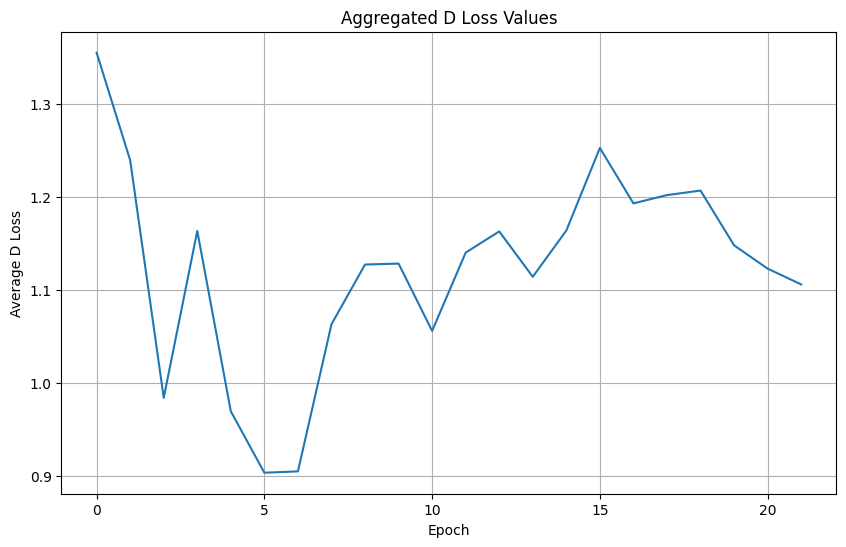

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(aggregated_loss_d, linestyle='-')
plt.title('Aggregated D Loss Values')
plt.xlabel('Epoch')
plt.ylabel('Average D Loss')
plt.savefig(f'Loss/D_Loss_Batch{BATCH}_Delta{DELTA}_{ATTACK}.png')
plt.grid(True)
plt.show()

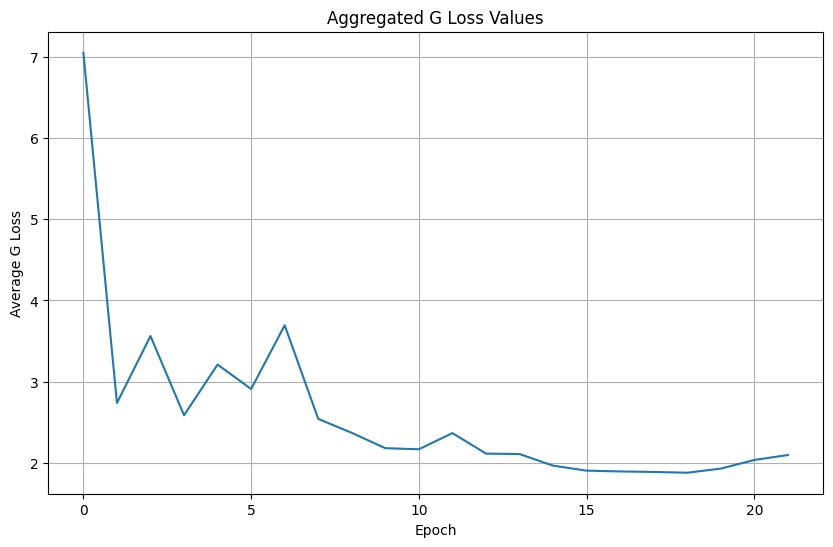

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(aggregated_loss_g, linestyle='-')
plt.title('Aggregated G Loss Values')
plt.xlabel('Epoch')
plt.ylabel('Average G Loss')
plt.savefig(f'Loss/G_Loss_Batch{BATCH}_Delta{DELTA}_{ATTACK}.png')
plt.grid(True)
plt.show()

## Image Inference

In [46]:
netG = Generator(1).to(device)
netG.load_state_dict(checkpoint['netG_state_dict'])
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [47]:
netE = Encoder().to(device)
netE.load_state_dict(checkpoint_encoder['netE_state_dict'])
netE.eval()

Encoder(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 100, kernel_size=(4, 4

In [48]:
class CustomDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)
        if self.transform:
            image = self.transform(image)
        filename = os.path.basename(path)
        class_name = self.classes[target]
        return image, filename, class_name

In [49]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataloader = DataLoader(CustomDataset(root=f"../Dataset/Imagewoof/train", transform=transform), batch_size=1, shuffle=True)

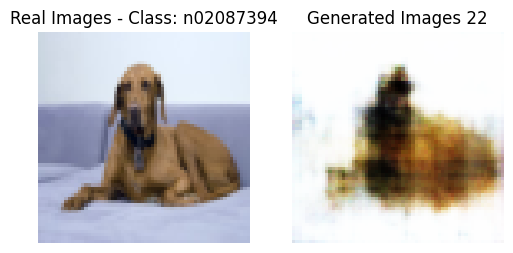

In [121]:
with torch.no_grad():
    for i, (real_images, filenames, class_names) in enumerate(dataloader):
        real_images = real_images.to(device)

        latent_vectors = netE(real_images) 
        
        # Reshape latent_vectors to match netG's expected input: [batch_size, 100, 1, 1]
        latent_vectors = latent_vectors.view(latent_vectors.size(0), latent_vectors.size(1), 1, 1)      

        noise = torch.randn(1, 100, 1, 1, device=device)
        fake_images = netG(latent_vectors).to("cpu")

        real_grid = vutils.make_grid(real_images.to("cpu"), normalize=True, padding=2)
        fake_grid = vutils.make_grid(fake_images, normalize=True, padding=2)

        # Save real images
        vutils.save_image(real_grid, f"01.jpg")

        # Save generated images
        vutils.save_image(fake_grid, f"01_adv.jpg")

        fig, axes = plt.subplots(1, 2, figsize=(6, 6))
        axes[0].imshow(real_grid.permute(1, 2, 0))
        axes[0].axis("off")
        axes[0].set_title(f"Real Images - Class: {class_names[0]}")

        axes[1].imshow(fake_grid.permute(1, 2, 0))
        axes[1].axis("off")
        axes[1].set_title(f"Generated Images {BEST_CHECKPOINT_G}")

        plt.show()
        break